# Initial setting

## libraries

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import re
import requests
from time import sleep
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from collections import OrderedDict

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

## dataset

In [3]:
# Load data
df = pd.read_csv('data/df_fifa.csv')

In [4]:
df.shape

(100995, 146)

In [5]:
df.head()

,sofifa_id,short_name,age,dob,height_cm,weight_kg,nationality,club,overall,value_eur,wage_eur,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,release_clause_eur,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,year,league_name,d_trait_Cautious_With_Crosses,d_trait_Injury_Prone,d_trait_Avoids_Using_Weaker_Foot,d_trait_Backs_Into_Player,d_trait_Flair,d_trait_Saves_with_Feet,d_trait_Leadership,d_trait_Inflexible,d_trait_Finesse_Shot,d_trait_Team_Player,d_trait_1-on-1_Rush,d_trait_Set_Play_Specialist,d_trait_Rushes_Out_Of_Goal,d_trait_Beat_Offside_Trap,d_trait_Early_Crosser,d_trait_Second_Wind,d_trait_Through_Ball,d_trait_Long_Throw-in,d_trait_Giant_Throw-in,d_trait_Diver,d_trait_Acrobatic_Clearance,d_trait_Selfish,d_trait_GK_Up_for_Corners,d_trait_Argues_with_Officials,d_trait_Takes_Finesse_Free_Kicks,...,d_pos_GK,ab_pace,ab_shooting,ab_passing,ab_dribbling,ab_defending,ab_physic,ab_skill_moves,ab_gk_diving,ab_gk_handling,ab_gk_kicking,ab_gk_reflexes,ab_gk_speed,ab_gk_positioning,ab_attacking_crossing,ab_attacking_finishing,ab_attacking_heading_accuracy,ab_attacking_short_passing,ab_attacking_volleys,ab_skill_dribbling,ab_skill_curve,ab_skill_fk_accuracy,ab_skill_long_passing,ab_skill_ball_control,ab_movement_acceleration,ab_movement_sprint_speed,ab_movement_agility,ab_movement_reactions,ab_movement_balance,ab_power_shot_power,ab_power_jumping,ab_power_stamina,ab_power_strength,ab_power_long_shots,ab_mentality_aggression,ab_mentality_interceptions,ab_mentality_positioning,ab_mentality_vision,ab_mentality_penalties,ab_mentality_composure,ab_defending_marking,ab_defending_standing_tackle,ab_defending_sliding_tackle,ab_goalkeeping_diving,ab_goalkeeping_handling,ab_goalkeeping_kicking,ab_goalkeeping_positioning,ab_goalkeeping_reflexes,d_foot_left,d_div1_league
0,158023,L. Messi,27,1987-06-24,169,67,Argentina,FC Barcelona,93,0,0,Left,5,3,4,Medium/Low,Normal,NaN,CF,10.0,NaN,2004-07-01,2018.0,2015,Spain Primera Division,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,93.0,89.0,86.0,96.0,27.0,63.0,4,NaN,NaN,NaN,NaN,NaN,NaN,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,NaN,25,21,20,6,11,15,14,8,1,1
1,20801,Cristiano Ronaldo,29,1985-02-05,185,80,Portugal,Real Madrid,92,0,0,Right,5,4,5,High/Low,Normal,NaN,LW,7.0,NaN,2009-07-01,2018.0,2015,Spain Primera Division,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,93.0,93.0,81.0,91.0,32.0,79.0,5,NaN,NaN,NaN,NaN,NaN,NaN,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,NaN,22,31,23,7,11,15,14,11,0,1
2,9014,A. Robben,30,1984-01-23,180,80,Netherlands,FC Bayern München,90,0,0,Left,5,2,4,High/Low,Normal,NaN,SUB,10.0,NaN,2009-08-28,2017.0,2015,German 1. Bundesliga,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,93.0,86.0,83.0,92.0,32.0,64.0,4,NaN,NaN,NaN,NaN,NaN,NaN,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,NaN,29,26,26,10,8,11,5,15,1,1
3,41236,Z. Ibrahimović,32,1981-10-03,195,95,Sweden,Paris Saint-Germain,90,0,0,Right,5,4,4,Medium/Low,Normal,NaN,ST,10.0,NaN,2012-07-01,2016.0,2015,French Ligue 1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,76.0,91.0,81.0,86.0,34.0,86.0,4,NaN,NaN,NaN,NaN,NaN,NaN,76,91,76,84,92,88,80,80,76,90,74,77,86,85,41,93,72,78,93,88,84,20,86,83,91,NaN,25,41,27,13,15,10,9,12,0,1
4,167495,M. Neuer,28,1986-03-27,193,92,Germany,FC Bayern München,90,0,0,Right,5,4,1,Medium/Medium,Normal,NaN,GK,1.0,NaN,2011-07-01,2019.0,2015,German 1. Bundesliga,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,1,87.0,85.0,92.0,86.0,60.0,90.0,25,25,25,42,25,25,25,25,41,31,58,61,43,89,35,42,78,44,83,25,29,30,25,20,37,NaN,25,25,25,87,85,92,90,86,0,1


# PartD

The overall approach for this part is as follows:
1. Create skill_summary column by taking a mean of all skill stats to use it as response variable
1. Create 5 different models using below as a training data set: 1) predicting 2016 from 2015 dataset, 2) predicting 2017 from 2016 dataset, 3) predicting 2018 from 2017 dataset, 4) predicting 2019 from 2018 dataset, 5) predicting 2020 from 2019 dataset.
1. Use above 5 models (XGBoost) and predict 2021 skill_summary stats from 2020 dataset.
1. Using the weight of 1) 0.15, 2)0.15, 3)0.20, 4)0.20, 5)0.30 to ensemble the models and make prediction. The weight is decided according to the fact that in the test to predict 2020 summary stats, the models trained by recent data had lower MSE score.

In [6]:
# create a list of skills and create skill_summary column by taking mean of them.
df['skill_summary'] = (df['ab_skill_dribbling'] + df['ab_skill_curve'] + df['ab_skill_fk_accuracy'] + df['ab_skill_long_passing'] + df['ab_skill_ball_control']) / 5

## Train 3 models using each year's dataset to predict skill_summary

### XGBOOST

In [7]:
# import packages
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [8]:
def partd_xgb(train_on, validate_on):
    # preprocessing
    # subset based on the inputed year
    df_tr = df[df['year']==train_on]
    df_val = df[df['year']==validate_on]

    # drop variables other than 'skill_summary'
    df_val_sk = df_val[['sofifa_id', 'skill_summary']]

    # merge and drop unnecessary columns/rows, imputation
    df_merge = df_tr.merge(df_val_sk, on='sofifa_id', how='left', suffixes=(None, '_r'))
    df_merge.dropna(subset=['skill_summary_r'], inplace=True)
    drop_vars = ['sofifa_id','short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
                'preferred_foot','joined','contract_valid_until','year','main_position','team_jersey_number', 'wage_eur', 'club', 'ab_mentality_composure']
    df_merge_drop = df_merge.drop(drop_vars, axis=1)

    impute_vars = ['ab_pace','ab_shooting','ab_passing','ab_dribbling','ab_defending','ab_physic','release_clause_eur']
    impute_vars = impute_vars + [x for x in df_merge_drop.columns if x.startswith('ab_gk')]
    for var in impute_vars:
        df_merge_drop[var] = df_merge_drop[var].fillna(0)
    
    # select players in the following clubs as per instruction
    select_clubs = [ 'English Premier League',  'German 1. Bundesliga',  'French Ligue 1', 'Spain Primera Division', 'Italian Serie A']
    df_selected = df_merge_drop[df_merge_drop.league_name.isin(select_clubs)].drop(['league_name'], axis=1)

    # separate X and y
    y = df_selected['skill_summary_r']
    X = df_selected.drop(['skill_summary_r'], axis=1)

    # random search
    param_space = {
        'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(10)),
        'max_depth': hp.quniform('max_depth', 3, 9, 1),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
        'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0))
    }

    def score(params):
        xgb = XGBRegressor(random_state=81, min_child_weight=params['min_child_weight'],
                          max_depth=int(params['max_depth']), subsample=params['subsample'], colsample_bytree=params['colsample_bytree'],
                          gamma=params['gamma'], reg_alpha =params['reg_alpha'], reg_lambda =params['reg_lambda']) #, booster=params['booster']
        scores = cross_validate(xgb, X=X, y=y, cv=5, scoring='neg_mean_squared_error')
        return -1 * scores['test_score'].mean()

    max_evals = 100
    trials = Trials()
    history = []
    rstate = np.random.RandomState(81)
    best = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

    # fit best model
    best_model = XGBRegressor(random_state=81, min_child_weight=best['min_child_weight'],
                          max_depth=int(best['max_depth']), subsample=best['subsample'], colsample_bytree=best['colsample_bytree'],
                          gamma=best['gamma'], reg_alpha =best['reg_alpha'], reg_lambda =best['reg_lambda']).fit(X, y)
    return best, best_model

In [9]:
def test_function(model):
    # get 2019 and 2020 data for training
    df_tr = df[df['year']==2019]
    df_val = df[df['year']==2020]

    # drop variables other than 'skill_summary' from df_2020
    df_val_sk = df_val[['sofifa_id', 'skill_summary']]

    # merge and drop unnecessary columns/rows, imputation
    df_merge = df_tr.merge(df_val_sk, on='sofifa_id', how='left', suffixes=(None, '_r'))
    df_merge.dropna(subset=['skill_summary_r'], inplace=True)
    drop_vars = ['sofifa_id','short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
                'preferred_foot','joined','contract_valid_until','year','main_position','team_jersey_number', 'wage_eur', 'club', 'club', 'ab_mentality_composure']
    df_merge_drop = df_merge.drop(drop_vars, axis=1)

    impute_vars = ['ab_pace','ab_shooting','ab_passing','ab_dribbling','ab_defending','ab_physic','release_clause_eur']
    impute_vars = impute_vars + [x for x in df_merge_drop.columns if x.startswith('ab_gk')]
    for var in impute_vars:
        df_merge_drop[var] = df_merge_drop[var].fillna(0)
    
    # select players in the following clubs as per instruction
    select_clubs = [ 'English Premier League',  'German 1. Bundesliga',  'French Ligue 1', 'Spain Primera Division', 'Italian Serie A']
    df_selected = df_merge_drop[df_merge_drop.league_name.isin(select_clubs)].drop(['league_name'], axis=1)

    # separate X and y
    y = df_selected['skill_summary_r']
    X = df_selected.drop(['skill_summary_r'], axis=1)
    
    te_pred = model.predict(X)
    test_score = mean_squared_error(y, te_pred)

    return test_score

In [10]:
result_xgb = {}
model_xgb = {}
for i in [2015, 2016, 2017, 2018, 2019]:
    best_param, best_model = partd_xgb(i, i+1)
    test_score = test_function(best_model)
    result_xgb[i] = test_score
    model_xgb[i] = best_model

100%|██████████| 100/100 [03:12<00:00,  1.93s/trial, best loss: 6.282732266597139]


In [11]:
print(f'The MSE on 2020 skill_summary prediction by XGBoost is 2015 model: {result_xgb[2015]:.3f}, 2016 model: {result_xgb[2016]:.3f}, 2017 model: {result_xgb[2017]:.3f}, 2018 model: {result_xgb[2018]:.3f}, 2019 model: {result_xgb[2019]:.3f}.')

The MSE on 2020 skill_summary prediction by XGBoost is 2015 model: 8.154, 2016 model: 6.333, 2017 model: 6.245, 2018 model: 6.073, 2019 model: 2.147.


### Random Forest model

In [12]:
# same code as above, but with Random Forest
def partd_rf(train_on, validate_on):
    # preprocessing
    # subset based on the inputed year
    df_tr = df[df['year']==train_on]
    df_val = df[df['year']==validate_on]

    # drop variables other than 'skill_summary'
    df_val_sk = df_val[['sofifa_id', 'skill_summary']]

    # merge and drop unnecessary columns/rows, imputation
    df_merge = df_tr.merge(df_val_sk, on='sofifa_id', how='left', suffixes=(None, '_r'))
    df_merge.dropna(subset=['skill_summary_r'], inplace=True)
    drop_vars = ['sofifa_id','short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
                'preferred_foot','joined','contract_valid_until','year','main_position','team_jersey_number', 'wage_eur', 'club', 'ab_mentality_composure']
    df_merge_drop = df_merge.drop(drop_vars, axis=1)

    impute_vars = ['ab_pace','ab_shooting','ab_passing','ab_dribbling','ab_defending','ab_physic','release_clause_eur']
    impute_vars = impute_vars + [x for x in df_merge_drop.columns if x.startswith('ab_gk')]
    for var in impute_vars:
        df_merge_drop[var] = df_merge_drop[var].fillna(0)
    
    # select players in the following clubs as per instruction
    select_clubs = [ 'English Premier League',  'German 1. Bundesliga',  'French Ligue 1', 'Spain Primera Division', 'Italian Serie A']
    df_selected = df_merge_drop[df_merge_drop.league_name.isin(select_clubs)].drop(['league_name'], axis=1)

    # separate X and y
    y = df_selected['skill_summary_r']
    X = df_selected.drop(['skill_summary_r'], axis=1)

    # random search
    param_space = {
        'max_depth': hp.quniform('max_depth', 3, 50, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 500, 5)
    }

    def score(params):
        depth = int(params['max_depth'])
        est = int(params['n_estimators'])

        rf = RandomForestRegressor(random_state=81, n_estimators=est, max_depth=depth, max_features=int(X.shape[1]/3))
        scores = cross_validate(rf, X=X, y=y, cv=5, scoring='neg_mean_squared_error')
        return -1 * scores['test_score'].mean()

    max_evals = 10
    trials = Trials()
    history = []
    rstate = np.random.RandomState(81)
    best = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

    # fit best model
    best_model = RandomForestRegressor(max_depth=int(best['max_depth']), n_estimators=int(best['n_estimators']), max_features=int(X.shape[1]/3), random_state=81).fit(X, y)
    return best, best_model

In [13]:
result_rf = {}
model_rf = {}
for i in [2015, 2016, 2017, 2018, 2019]:
    best_param, best_model = partd_rf(i, i+1)
    test_score = test_function(best_model)
    result_rf[i] = test_score
    model_rf[i] = best_model

100%|██████████| 10/10 [03:06<00:00, 18.68s/trial, best loss: 5.81966716380582]


In [14]:
print(f'The MSE of Random Forest is 2015 model: {result_rf[2015]:.3f}, 2016 model: {result_rf[2016]:.3f}, 2017 model: {result_rf[2017]:.3f}, 2018 model: {result_rf[2018]:.3f}, 2019 model: {result_rf[2019]:.3f}.')

The MSE of Random Forest is 2015 model: 6.581, 2016 model: 5.273, 2017 model: 5.243, 2018 model: 5.121, 2019 model: 0.758.


### Linear Regression - Elastic Net

In [15]:
from sklearn.linear_model import ElasticNet

In [16]:
# same code as above, but with Random Forest
def partd_en(train_on, validate_on):
    # preprocessing
    # subset based on the inputed year
    df_tr = df[df['year']==train_on]
    df_val = df[df['year']==validate_on]

    # drop variables other than 'skill_summary'
    df_val_sk = df_val[['sofifa_id', 'skill_summary']]

    # merge and drop unnecessary columns/rows, imputation
    df_merge = df_tr.merge(df_val_sk, on='sofifa_id', how='left', suffixes=(None, '_r'))
    df_merge.dropna(subset=['skill_summary_r'], inplace=True)
    drop_vars = ['sofifa_id','short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
                'preferred_foot','joined','contract_valid_until','year','main_position','team_jersey_number', 'wage_eur', 'club', 'club', 'ab_mentality_composure']
    df_merge_drop = df_merge.drop(drop_vars, axis=1)

    impute_vars = ['ab_pace','ab_shooting','ab_passing','ab_dribbling','ab_defending','ab_physic','release_clause_eur']
    impute_vars = impute_vars + [x for x in df_merge_drop.columns if x.startswith('ab_gk')]
    for var in impute_vars:
        df_merge_drop[var] = df_merge_drop[var].fillna(0)
    
    # select players in the following clubs as per instruction
    select_clubs = [ 'English Premier League',  'German 1. Bundesliga',  'French Ligue 1', 'Spain Primera Division', 'Italian Serie A']
    df_selected = df_merge_drop[df_merge_drop.league_name.isin(select_clubs)].drop(['league_name'], axis=1)
    
    # separate X and y
    y = df_selected['skill_summary_r']
    X = df_selected.drop(['skill_summary_r'], axis=1)

    # random search
    param_space = {
        'alpha': hp.uniform('alpha', 0.1, 1)
    }

    def score(params):
        alpha = (params['alpha'])

        en = ElasticNet(random_state=81, alpha=alpha, max_iter=100000)
        scores = cross_validate(en, X=X, y=y, cv=5, scoring='neg_mean_squared_error')
        return -1 * scores['test_score'].mean()

    max_evals = 10
    trials = Trials()
    history = []
    rstate = np.random.RandomState(81)
    best = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

    # fit best model
    best_model = ElasticNet(random_state=81, alpha=best['alpha'], max_iter=100000).fit(X, y)
    return best, best_model

In [17]:
result_el = {}
model_el = {}
for i in [2015, 2016, 2017, 2018, 2019]:
    best_param, best_model = partd_en(i, i+1)
    test_score = test_function(best_model)
    result_el[i] = test_score
    model_el[i] = best_model

100%|██████████| 10/10 [00:42<00:00,  4.23s/trial, best loss: 5.0058659846631555]


In [18]:
print(f'The MSE by Elastic Net model: 2015 model: {result_el[2015]:.3f}, 2016 model: {result_el[2016]:.3f}, 2017 model: {result_el[2017]:.3f}, 2018 model: {result_el[2018]:.3f}, 2019 model: {result_el[2019]:.3f}.')

The MSE by Elastic Net model: 2015 model: 7.904, 2016 model: 5.051, 2017 model: 5.016, 2018 model: 4.938, 2019 model: 4.810.


In [19]:
# dataframe to summarize all test result
df_result = pd.DataFrame({'xgb': result_xgb, 'rf': result_rf, 'el': result_el}).T
df_result['average'] = (df_result[2015] + df_result[2016] + df_result[2017] + df_result[2017] + df_result[2019]) / 5
display(df_result)

,2015,2016,2017,2018,2019,average
xgb,8.154486,6.333230,6.245500,6.073099,2.146581,5.825059
rf,6.580517,5.273476,5.243323,5.120725,0.758379,4.619804
el,7.904130,5.050935,5.016124,4.937940,4.809635,5.559390


## predict 2021 ball_control skill score from 2020 data using ensemble model

In [20]:
df_2020 = df[df['year'] == 2020]

In [21]:
# preprocess 2020 data
# drop unnecessary columns
drop_vars = ['sofifa_id','short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
            'preferred_foot','joined','contract_valid_until','year','main_position','team_jersey_number', 'wage_eur', 'club', 'club', 'ab_mentality_composure']
df_2020_drop = df_2020.drop(drop_vars, axis=1)

impute_vars = ['ab_pace','ab_shooting','ab_passing','ab_dribbling','ab_defending','ab_physic','release_clause_eur']
impute_vars = impute_vars + [x for x in df_2020_drop.columns if x.startswith('ab_gk')]
for var in impute_vars:
    df_2020_drop[var] = df_2020_drop[var].fillna(0)

# select players in the following clubs as per instruction
select_clubs = [ 'English Premier League',  'German 1. Bundesliga',  'French Ligue 1', 'Spain Primera Division', 'Italian Serie A']
df_2020_test = df_2020_drop[df_2020_drop.league_name.isin(select_clubs)].drop(['league_name'], axis=1)

In [22]:
# making prediction for 2021 skill score
prediction = {}

for i in [2015, 2016, 2017, 2018, 2019]:
    for num, model in enumerate([model_xgb, model_rf, model_el]):
        model_pred = model[i]
        prediction_2021 = model_pred.predict(df_2020_test)
        prediction[i, num] = prediction_2021        
df_ensemble = pd.DataFrame(prediction)

# apply weight (please see presentation for detail)
df_ensemble['final_prediction'] = df_ensemble[2015][0] * 0.045 + df_ensemble[2015][1] * 0.06 + df_ensemble[2015][2] * 0.045 + df_ensemble[2016][0] * 0.045 + df_ensemble[2016][1] * 0.06 + df_ensemble[2016][2] * 0.045 + df_ensemble[2017][0] * 0.06 + df_ensemble[2017][1] * 0.08 + df_ensemble[2017][2] * 0.06 + df_ensemble[2018][0] * 0.06 + df_ensemble[2018][1] * 0.08 + df_ensemble[2018][2] * 0.06 + df_ensemble[2019][0] * 0.09 + df_ensemble[2019][1] * 0.12 + df_ensemble[2019][2] * 0.09

In [23]:
# integrate sofifa_id to the final dataframe for easy grading

# drop unnecessary columns, keep sofifa_id
drop_vars = ['short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
            'preferred_foot','joined','contract_valid_until','year','main_position','team_jersey_number', 'wage_eur', 'club', 'club', 'ab_mentality_composure']
df_2020_drop = df_2020.drop(drop_vars, axis=1)

impute_vars = ['ab_pace','ab_shooting','ab_passing','ab_dribbling','ab_defending','ab_physic','release_clause_eur']
impute_vars = impute_vars + [x for x in df_2020_drop.columns if x.startswith('ab_gk')]
for var in impute_vars:
    df_2020_drop[var] = df_2020_drop[var].fillna(0)

# select players in the following clubs as per instruction
select_clubs = [ 'English Premier League',  'German 1. Bundesliga',  'French Ligue 1', 'Spain Primera Division', 'Italian Serie A']
df_2020_test = df_2020_drop[df_2020_drop.league_name.isin(select_clubs)].drop(['league_name'], axis=1)
df_id = df_2020_test['sofifa_id']
print(df_id.shape)

df_id_new = pd.DataFrame(df_id).reset_index()
df_ensemble['sofifa_id'] = df_id_new['sofifa_id']

(3039,)


In [24]:
# export in csv
df_ensemble.to_csv('partd/final_prediction_partd.csv')

## Check some players historical and predicted skill_summary

In [25]:
# load necessary files
result = pd.read_csv('partd/final_prediction_partd.csv')
result_2021 = result[['final_prediction', 'sofifa_id']].dropna()
df_player_list = pd.read_csv("data/player_list.csv")

# create list for id and name
id_list = df_player_list['sofifa_id']
name = df_player_list['short_name']

In [26]:
# subset dataframe so that it only has necessary players info
df_selected = df[df['sofifa_id'].isin(id_list)]
df_selected_merge = df_selected[['year', 'skill_summary', 'sofifa_id', 'short_name']] #.merge(result_new, on='sofifa_id')

In [27]:
# create dictionary to save each players historical skill summary score
player_stats = {}
for sofifa_id in id_list:
    player = df_selected_merge[df_selected_merge['sofifa_id'] == sofifa_id]
    player_stats[sofifa_id] = player['skill_summary'].values

In [28]:
# comparing actual data with predicted data
for year in [2016, 2017, 2018, 2019, 2020]:
    df_year = df[df['year'] == year]
    
    # preprocess 2020 data
    # drop unnecessary columns
    drop_vars = ['sofifa_id','short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
                'preferred_foot','joined','contract_valid_until','year','main_position','team_jersey_number', 'wage_eur', 'club', 'ab_mentality_composure']
    df_year_drop = df_year.drop(drop_vars, axis=1)

    impute_vars = ['ab_pace','ab_shooting','ab_passing','ab_dribbling','ab_defending','ab_physic','release_clause_eur']
    impute_vars = impute_vars + [x for x in df_year_drop.columns if x.startswith('ab_gk')]
    for var in impute_vars:
        df_year_drop[var] = df_year_drop[var].fillna(0)

    # select players in the following clubs as per instruction
    select_clubs = [ 'English Premier League',  'German 1. Bundesliga',  'French Ligue 1', 'Spain Primera Division', 'Italian Serie A']
    df_year_test = df_year_drop[df_year_drop.league_name.isin(select_clubs)].drop(['league_name'], axis=1)
    
    # making prediction for 2021 skill score
    prediction = {}

    for i in [2015, 2016, 2017, 2018, 2019]:
        for num, model in enumerate([model_xgb, model_rf, model_el]):
            model_pred = model[i]
            prediction_next_year = model_pred.predict(df_year_test)
            prediction[i, num] = prediction_next_year        
    df_ensemble = pd.DataFrame(prediction)

    # apply weight (please see presentation for detail)
    df_ensemble['final_prediction'] = df_ensemble[2015][0] * 0.0375 + df_ensemble[2015][1] * 0.06 + df_ensemble[2015][2] * 0.0525 + df_ensemble[2016][0] * 0.0375 + df_ensemble[2016][1] * 0.06 + df_ensemble[2016][2] * 0.0525 + df_ensemble[2017][0] * 0.05 + df_ensemble[2017][1] * 0.08 + df_ensemble[2017][2] * 0.07 + df_ensemble[2018][0] * 0.05 + df_ensemble[2018][1] * 0.08 + df_ensemble[2018][2] * 0.07 + df_ensemble[2019][0] * 0.075 + df_ensemble[2019][1] * 0.12 + df_ensemble[2019][2] * 0.105
    
    # integration with sofifa_id
    drop_vars = ['short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
                'preferred_foot','joined','contract_valid_until','year','main_position','team_jersey_number', 'wage_eur', 'club', 'club', 'ab_mentality_composure']
    df_year_drop_id = df_year.drop(drop_vars, axis=1)

    impute_vars = ['ab_pace','ab_shooting','ab_passing','ab_dribbling','ab_defending','ab_physic','release_clause_eur']
    impute_vars = impute_vars + [x for x in df_year_drop_id.columns if x.startswith('ab_gk')]
    for var in impute_vars:
        df_year_drop_id[var] = df_year_drop_id[var].fillna(0)

    # select players in the following clubs as per instruction
    select_clubs = [ 'English Premier League',  'German 1. Bundesliga',  'French Ligue 1', 'Spain Primera Division', 'Italian Serie A']
    df_year_test = df_year_drop_id[df_year_drop_id.league_name.isin(select_clubs)].drop(['league_name'], axis=1)
    df_id = df_year_test['sofifa_id']
    print(df_id.shape)

    df_id_new = pd.DataFrame(df_id).reset_index()
    df_ensemble['sofifa_id'] = df_id_new['sofifa_id']
    df_ensemble_new = df_ensemble[['sofifa_id', 'final_prediction']]
    df_ensemble_new.to_csv(f'partd/{year}_prediction.csv')

(2615,)
(2830,)
(2855,)
(2913,)
(3039,)


In [29]:
# create separate dataframe for each year's prediction
df_2016 = pd.read_csv('partd/2016_prediction.csv')
df_2017 = pd.read_csv('partd/2017_prediction.csv')
df_2018 = pd.read_csv('partd/2018_prediction.csv')
df_2019 = pd.read_csv('partd/2019_prediction.csv')
df_2020 = pd.read_csv('partd/2020_prediction.csv')

In [30]:
# combine dataframe
df_vis = df_2016.copy()
df_vis = df_vis[df_vis['sofifa_id'].isin(id_list)]
df_vis_merged = df_vis.merge(df_2017, on='sofifa_id', suffixes=('', '_2017')).merge(df_2018, on='sofifa_id', suffixes=('', '_2018')).merge(df_2019, on='sofifa_id', suffixes=('', '_2019')).merge(df_2020, on='sofifa_id', suffixes=('', '_2020')).merge(result_2021, on='sofifa_id', suffixes=('', '_2021'))

In [31]:
# change column names for easier understanding
df_vis_final = df_vis_merged[['sofifa_id', 'final_prediction', 'final_prediction_2017', 'final_prediction_2018', 'final_prediction_2019', 'final_prediction_2020', 'final_prediction_2021']]
df_vis_final = df_vis_final.rename(columns={'final_prediction': '2016_pred', 'final_prediction_2017': '2017_pred', 'final_prediction_2018': '2018_pred', 'final_prediction_2019': '2019_pred', 'final_prediction_2020': '2020_pred', 'final_prediction_2021': '2021_pred'})
df_vis_final_index = df_vis_final.set_index('sofifa_id')
display(df_vis_final_index)

,2016_pred,2017_pred,2018_pred,2019_pred,2020_pred,2021_pred
sofifa_id,,,,,,
158023.0,89.363580,89.960748,90.450910,91.191415,90.816325,90.562926
20801.0,83.930563,83.004328,83.730094,83.004856,82.866377,82.931419
183277.0,85.391194,84.699850,85.695873,86.768768,86.687785,86.643999
190871.0,81.798092,84.879718,86.301743,88.337875,88.629503,88.528483
188545.0,76.241590,76.689460,80.239867,80.417415,79.844402,79.855704
138956.0,53.343727,52.037235,53.435848,53.391741,55.115007,55.168892
155862.0,70.398151,70.675552,71.546277,71.509471,74.862731,74.896210
177003.0,83.520393,83.877210,84.057603,86.268287,85.498690,85.485641
192985.0,82.174781,82.374692,85.333747,86.874476,86.663410,86.610709


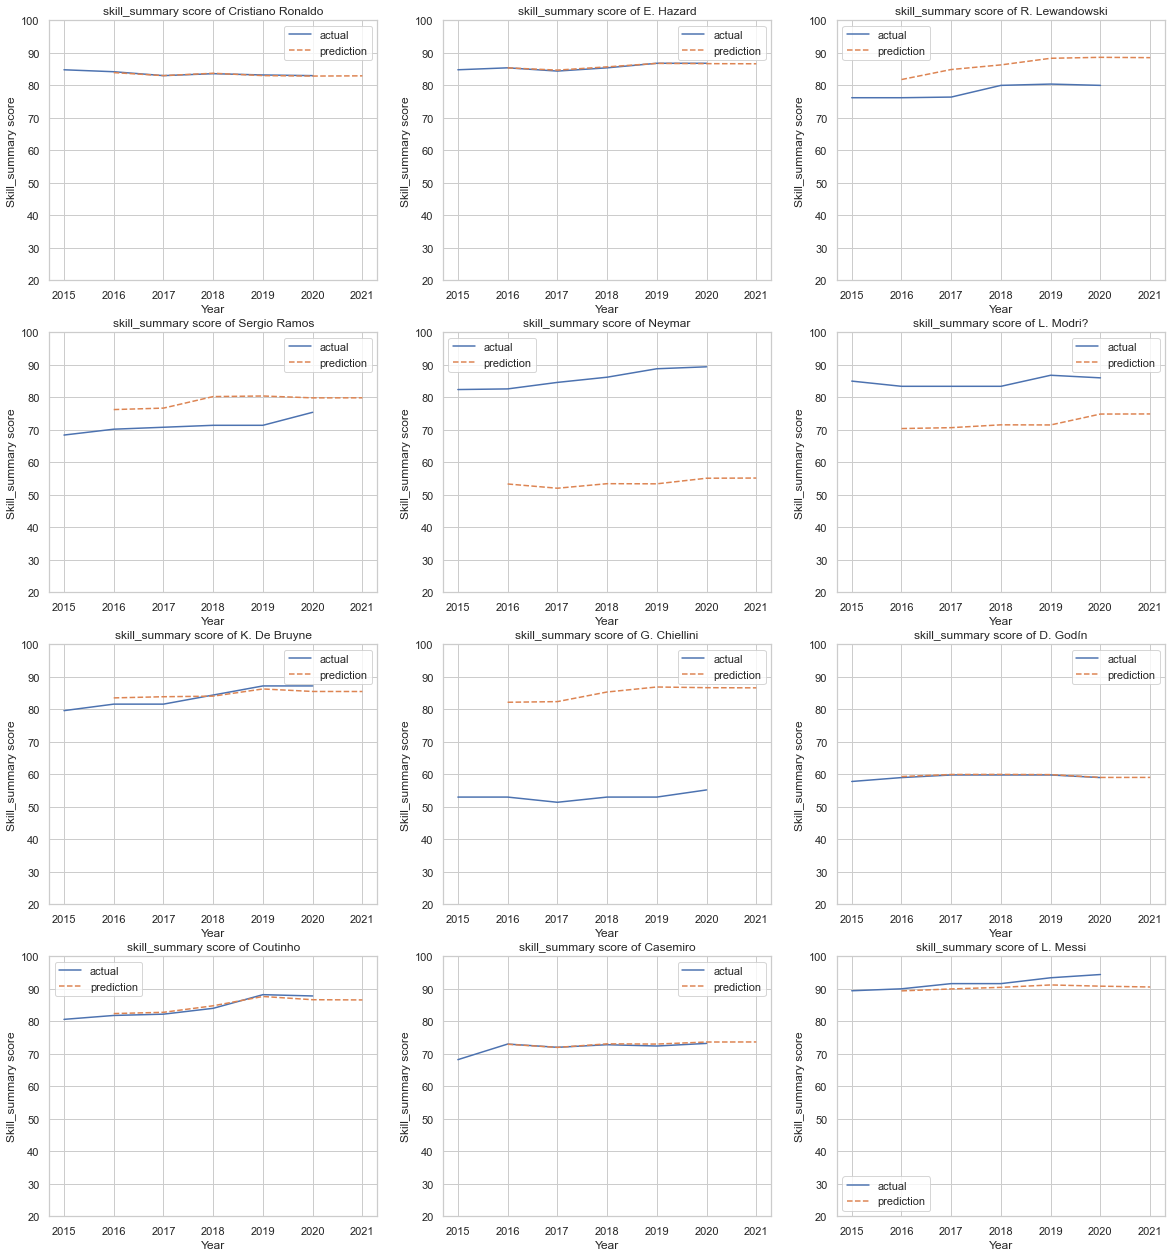

In [32]:
# visualization
fig, ax = plt.subplots(4, 3, figsize = (20, 22))
ax = ax.ravel()

actual_year = [2015, 2016, 2017, 2018, 2019, 2020]
pred_year = [2016, 2017, 2018, 2019, 2020, 2021]

for i in range(len(id_list)):
    ax[i-1].plot(actual_year, list(player_stats.values())[i], label='actual')
    ax[i-1].plot(pred_year, df_vis_final_index.iloc[i], linestyle="dashed", label='prediction')
    ax[i-1].set_xlabel('Year')
    ax[i-1].legend()
    ax[i-1].set_ylim(20, 100)
    ax[i-1].set_ylabel('Skill_summary score')
    ax[i-1].set_title(f'skill_summary score of {name[i]}')      